#Project 1 - Revisited

The goal of this project is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

Link to original datasource [Here](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

### Import Libraries


In [1]:
# standard imports
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

## Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Regression Metrics
from sklearn import metrics

#permutation Importance
from sklearn.inspection import permutation_importance

#saving model
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

## set pandas to display more columns
pd.set_option('display.max_columns',50)

#suppressing scientific notation, add comma & round 2 decimal pts
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

### Functions

In [2]:
"""Evaluates regression model with MAE, r-squared and RMSE and prints Dataframe""" 
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model', ):
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),7)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),7)

  ## Output Dataframe
  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_mae, test_mae,
                                               train_rmse, test_rmse,
                                               train_r2, test_r2]

  return scores


"""Evaluates a scikit learn regression model using r-squared and RMSE"""    
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


""" Function for extracting important features"""
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances


""" Function for plotting important features"""
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax


""" Function to get coefficients from a linear regression model"""
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

""" Function to annotate horizontal bars in coefficient graph"""
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)


""" Function to plot coefficients"""
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

### Upload Data

In [3]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filename = '/content/drive/MyDrive/Coding Dojo/Stack 2 - Machine Learning/06 Wk 6 Regression Models/Data Files/sales_predictions (2).csv'
df = pd.read_csv(filename)
#displaying first 3 rows
df.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.14"
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.27"


##Inspecting Data

In [5]:
#verifying how many rows/columns, datatypes, missing items and duplicate rows
print(df.info())
print(('-'*30))
print(f'There are {df.duplicated().sum()} duplicate rows.')
print(('-'*30))
print(f'There are {df.isna().sum().sum()} missing values.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None
------------------------------
There are

###Checking for any outliers or odd values in the data

In [6]:
#Summary statistics for the integer values
df.describe().round(4)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


In [7]:
#Summary statistics for the object values
df.describe(include=object)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


###Checking for inconsistencies in categorical columns and their counts

In [8]:
#creating a list of object columns
object_list = list(df.select_dtypes(include='object'))

In [9]:
#looping thru object columns to verify inconsistencies and how many categories in each
for each in object_list:
  print(f'Column Name: {each}')
  print(df[each].value_counts())
  print('\n')

Column Name: Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Column Name: Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Column Name: Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Column Name: Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OU

In [10]:
#Addressing inconsistencies in 'Item_Fat_Content' columnn
df.replace({'LF': 'Low Fat', 'reg': 'Regular', 'low fat': 'Low Fat'}, inplace = True)
#verifying changes were made
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

###Types of Values

Numeric Values
- Item_Visibility
- Item_Weight (Will be addressing missing values using Mean weight value)
- Item_MRP
- Outlet_Establishment_Year

Ordinal Values
- Outlet_Location_Type (Tier1,Tier2,Tier3)

Nominal Values
- Item_Identifier (Will be dropping column due to high cardinality)                           
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size (This is Small, Medium and High but I will be filling missing items with a new Unknown category)
- Outlet_Type 

##Exploratory Data Analysis

###Correlation Heat Map

<ipython-input-11-027b51488610>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,cmap='Blues');


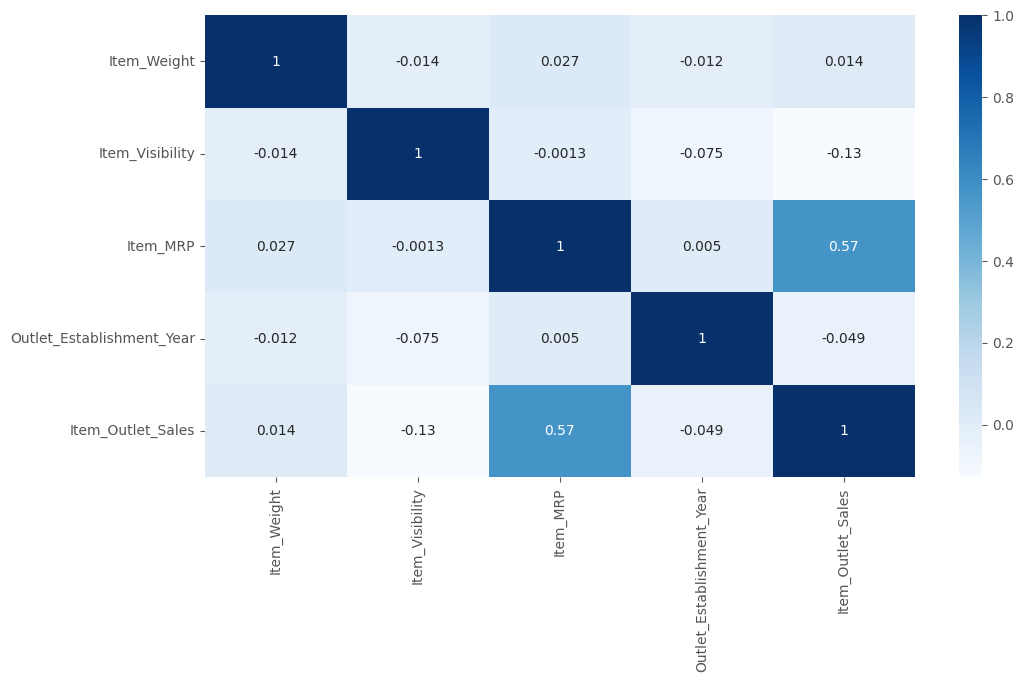

In [11]:
#creating a heat map
plt.style.use('ggplot')
plt.figure(figsize=(11.45,6))
sns.heatmap(df.corr(),annot=True,cmap='Blues');

>From the Correlation Heatmap above the only decent correlation I see is between the Item_Outlet_Sales and the Item_MRP (0.57). Besides that, there is pretty much no correlation between any of the other columns.

###Creating a graph to show Item Outlet Sales by Item Type

In [12]:
#filtering data
SalesbyItemType = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().round(2)
#sorting data
SortedSalesbyItemType = SalesbyItemType.sort_values()
SortedSalesbyItemType

Item_Type
Others                  1,926.14
Baking Goods            1,952.97
Soft Drinks             2,006.51
Health and Hygiene      2,010.00
Breakfast               2,111.81
Frozen Foods            2,132.87
Hard Drinks             2,139.22
Meat                    2,158.98
Breads                  2,204.13
Canned                  2,225.19
Dairy                   2,232.54
Household               2,258.78
Snack Foods             2,277.32
Fruits and Vegetables   2,289.01
Seafood                 2,326.07
Starchy Foods           2,374.33
Name: Item_Outlet_Sales, dtype: float64

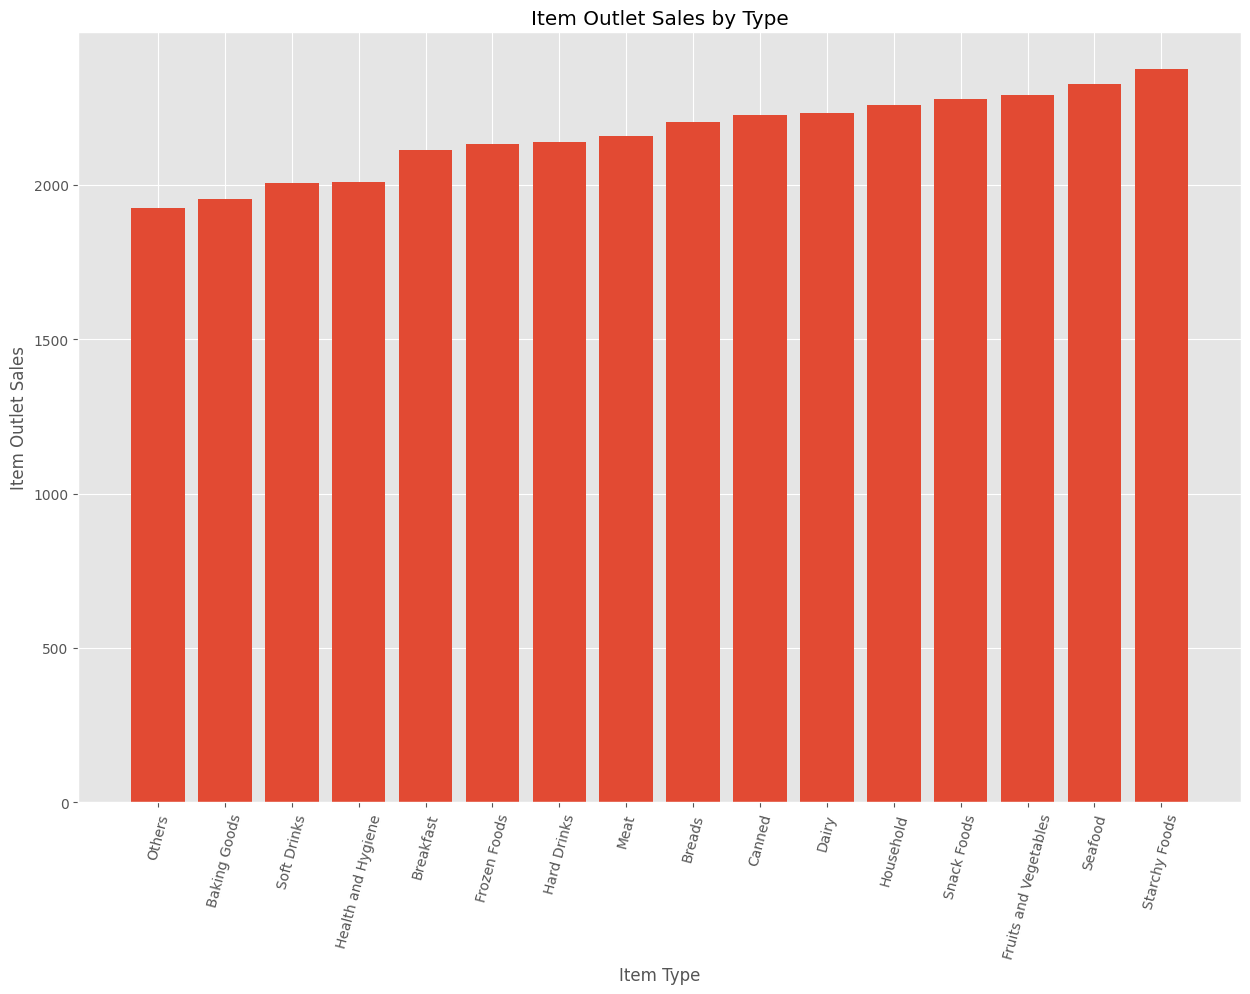

In [13]:
#plot graph
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyItemType.index, SortedSalesbyItemType.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Item Type')
plt.title('Item Outlet Sales by Type')
plt.xticks(rotation=75);

>Based on the graph above we know that the Starchy Food Items have the most Outlet Sales and Others has the least sales. There isn't an item with overwhelmingly more sales in comparison to other items. Sales are pretty similar across the board.

###Creating a graph to show Item Outlet Sales by Outlet Identifier

In [14]:
#filtering data
SalesbyOutlet = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().round(2)
#sorting data
SortedSalesbyOutlet = SalesbyOutlet.sort_values()
SortedSalesbyOutlet

Outlet_Identifier
OUT010     339.35
OUT019     340.33
OUT018   1,995.50
OUT045   2,192.38
OUT046   2,277.84
OUT013   2,299.00
OUT017   2,340.68
OUT049   2,348.35
OUT035   2,438.84
OUT027   3,694.04
Name: Item_Outlet_Sales, dtype: float64

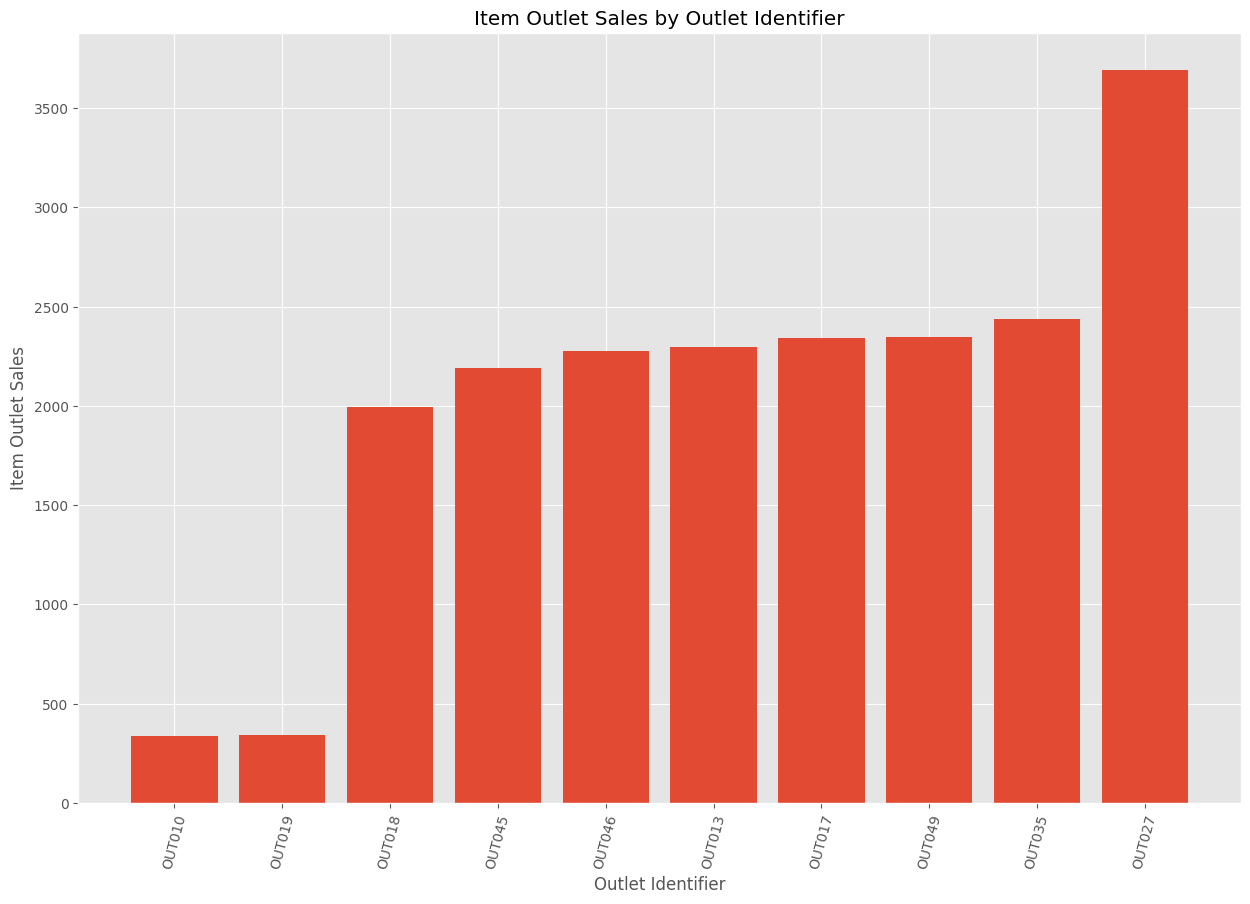

In [15]:
#plot graph
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyOutlet.index, SortedSalesbyOutlet.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Outlet Identifier')
plt.title('Item Outlet Sales by Outlet Identifier')
plt.xticks(rotation=75);

> I am showing based on the graph above that Outlet # OUT027 has the most sales while the outlets OUT010 and OUT019 have the least amount of sales. All the other outlets have somewhat similar sales compared to one another.

###Creating a graph to show Item Outlet Sales by Outlet Type

In [16]:
#filtering data
SalesbyOutletType = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().round(2)
#sorting data
SortedSalesbyOutletType = SalesbyOutletType.sort_values()
SortedSalesbyOutletType

Outlet_Type
Grocery Store         339.83
Supermarket Type2   1,995.50
Supermarket Type1   2,316.18
Supermarket Type3   3,694.04
Name: Item_Outlet_Sales, dtype: float64

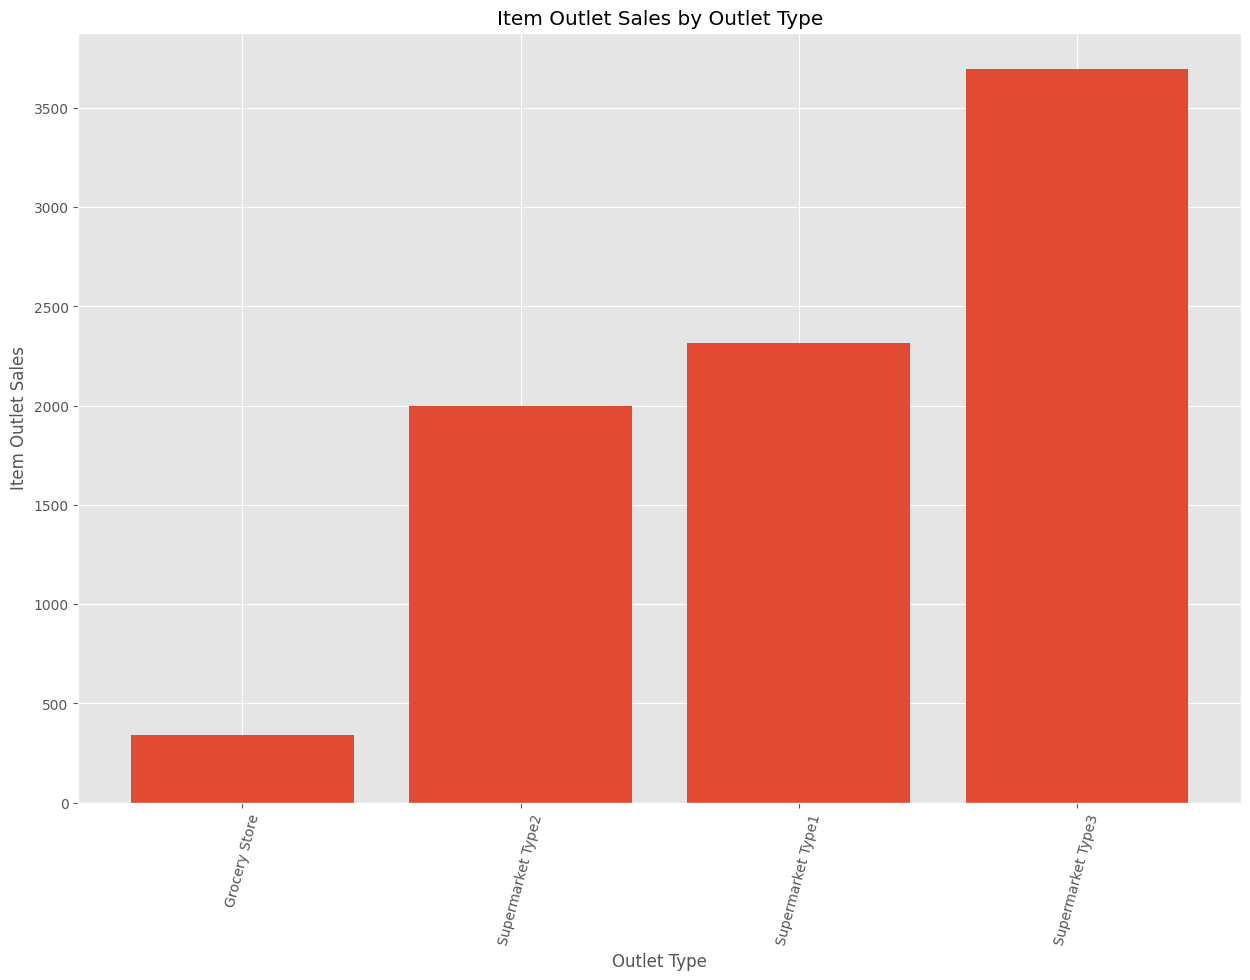

In [17]:
#plot graph
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyOutletType.index, SortedSalesbyOutletType.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Outlet Type')
plt.title('Item Outlet Sales by Outlet Type')
plt.xticks(rotation=75);

>I am seeing from the above graph that there is definitely a difference between the Outlet with the most and least sales. Supermarket Type 3 has the most Outlet Item Sales and Grocery Store has the least amount of Item Outlet Sales.

###Creating a graph to show Item Outlet Sales by Outlet Size

In [18]:
#filtering data
SalesbyOutletSize = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().round(2)
#sorting data
SortedSalesbyOutletSize = SalesbyOutletSize.sort_values()
SortedSalesbyOutletSize

Outlet_Size
Small    1,912.15
High     2,299.00
Medium   2,681.60
Name: Item_Outlet_Sales, dtype: float64

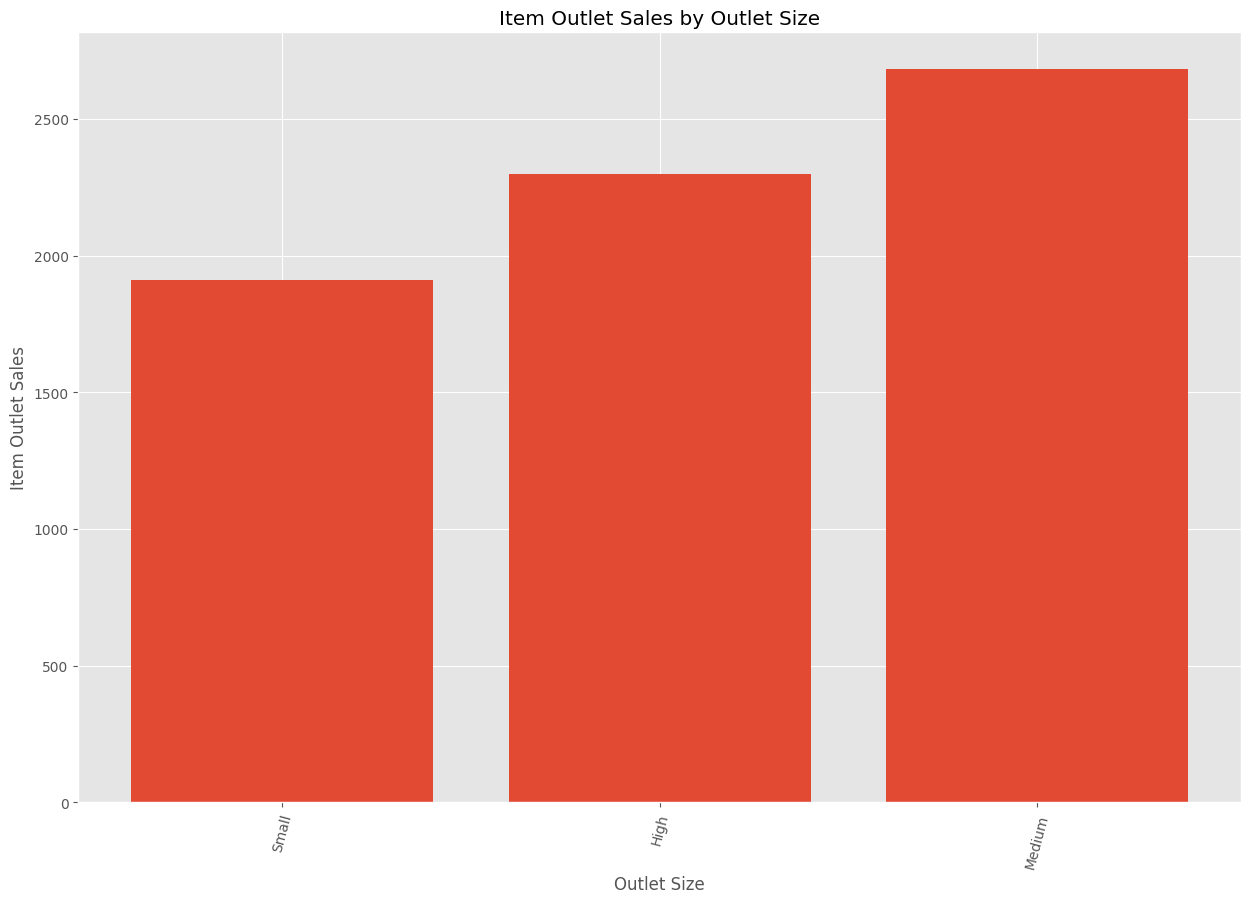

In [19]:
#plot graph
plt.figure(figsize=(15,10))
plt.bar(SortedSalesbyOutletSize.index, SortedSalesbyOutletSize.values)
plt.ylabel('Item Outlet Sales')
plt.xlabel('Outlet Size')
plt.title('Item Outlet Sales by Outlet Size')
plt.xticks(rotation=75);

>The graph above shows that Medium sized outlets sell the most and Small outlets sell the least.

###Creating a Chart showing Sales grouped by both Item Types and the Item Fat Content

In [20]:
#filtering data
Itemtypes = df.groupby(['Item_Type','Item_Fat_Content']).mean().reset_index()
#sorting data
Itemtypes = Itemtypes.sort_values(by = 'Item_Outlet_Sales')
#displaying last 5 rows
Itemtypes[:5]

<ipython-input-20-333c59eeba08>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Itemtypes = df.groupby(['Item_Type','Item_Fat_Content']).mean().reset_index()


,Item_Type,Item_Fat_Content,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,Baking Goods,Low Fat,12.55,0.07,120.53,"1,997.31","1,764.51"
25,Soft Drinks,Regular,11.23,0.07,121.77,"1,997.80","1,854.07"
20,Seafood,Low Fat,13.81,0.05,113.51,"1,997.19","1,907.79"
5,Breakfast,Regular,13.34,0.08,127.84,"1,997.36","1,925.46"
19,Others,Low Fat,13.85,0.06,132.85,"1,997.66","1,926.14"


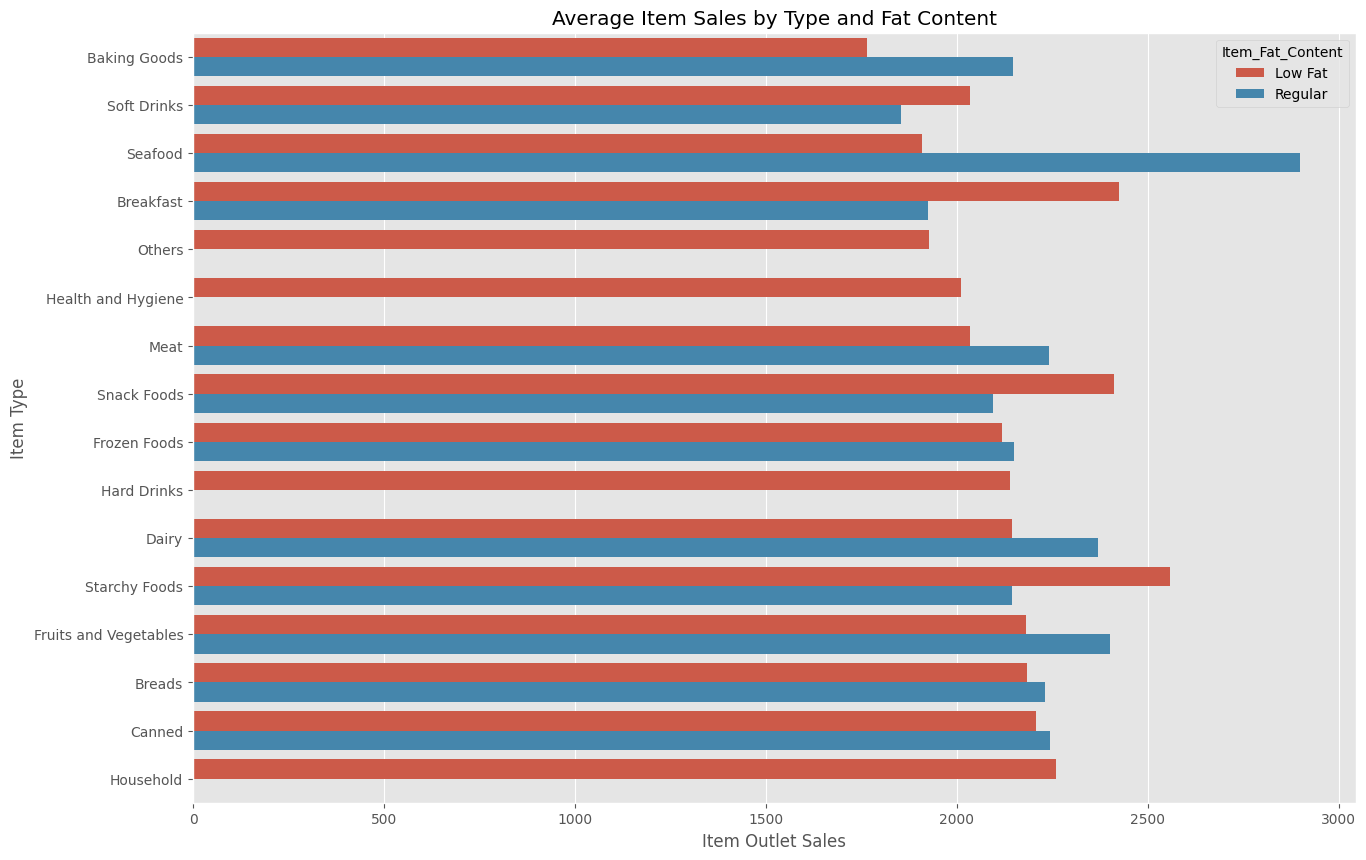

In [21]:
#plot graph
plt.figure(figsize=(15,10))
sns.barplot(data = Itemtypes, x = 'Item_Outlet_Sales', y = 'Item_Type', hue = 'Item_Fat_Content')
plt.title('Average Item Sales by Type and Fat Content')
plt.ylabel('Item Type')
plt.xlabel('Item Outlet Sales');

Based on the above graph:

Item Outlet Sales sell more Low Fat items in the following categories:
- Soft Drinks
- Breakfast
- Snack Foods
-Starchy Foods

Item Outlet Sales sell more Regular items in the following categories:
- Baking Goods
- Seafood
- Mean
- Frozen Foods
- Dairy
- Fruits & Vegetables
- Breads
- Canned

The below items only have one category of items since they would fall outside of the what is considered Low Fat and Regular:
- Household
- Others
- Health & Hygiene
- Hard Drinks

##Preprocessing data for ML

###Dropping irrevelant columns

In [22]:
#dropping Item_Identifier due to high cardinality(too many unique values)
df.drop(columns='Item_Identifier', inplace=True)
#confirming column was dropped
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

###Addressing Ordinal Values

In [23]:
#checking category counts prior to converting
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [24]:
#replacing category values
df['Outlet_Location_Type'].replace({'Tier 1':0, 'Tier 2':1, 'Tier 3':2}, inplace=True)

#confirming changes were made
df['Outlet_Location_Type'].value_counts()

2    3350
1    2785
0    2388
Name: Outlet_Location_Type, dtype: int64

### Verifying Missing Values

In [25]:
#Identifying missing values
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

* I will address the missing items in the 'Item_Weight' column with a Mean SimpleImputer after splitting my data. 
* For 'Outlet_Size' I decided to add an 'Unknown' category since the amount of missing data (2410) is very similar to the counts of other categories.

##Validation Split

###Assigning values for Features(X) and Target(y)

In [26]:
## Make X and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales']).copy()

###Splitting data into Training and Testing datasets

In [27]:
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
#displaying training features first 3 rows
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.22,Regular,0.06,Baking Goods,61.25,OUT010,1998,NaN,2,Grocery Store
7604,6.13,Low Fat,0.08,Soft Drinks,111.29,OUT018,2009,Medium,2,Supermarket Type2
2762,12.15,Low Fat,0.03,Household,151.07,OUT035,2004,Small,1,Supermarket Type1


##Creating Preprocessor

In [28]:
## make categorical and numerical selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

In [29]:
#verifying unique values for columns that will be onehotencoded
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Identifier:
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

For Outlet_Size:
['Medium' nan 'High' 'Small']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [30]:
drop_cats = ['Regular', 'Others', 'OUT049','Unknown','Grocery Store']

In [31]:
## instantiate transformers and make pipelines for categorical vs numeric data #drop=drop_cats or #handle_unknown='ignore'
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='Unknown'),
                         OneHotEncoder(drop=drop_cats, sparse_output=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())

In [32]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a40ea03d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop=['Regular',
                                                                      'Others',
                                                                      'OUT049',
                                                                      'Unknown',
                                                                      'Grocery '
                                                                      'Store'],
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a3dce9fc0>)],
                  verbose_feature_names_out=False)

In [33]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Location_Type',
       'Item_Fat_Content_Low Fat', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_

In [34]:
# create a preprocessed DataFrame for training set
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,-1.32,-0.04,-1.27,0.03,1.10,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7604,-1.57,0.25,-0.46,1.34,1.10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2762,-0.16,-0.73,0.18,0.74,-0.13,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [35]:
# create a preprocessed DataFrame for test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,0.57,-0.09,-0.12,1.10,-0.13,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2391,1.18,-0.42,-0.20,-0.09,-1.36,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
163,-1.31,0.09,-0.41,-0.09,-1.36,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00


In [36]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

8077   1,696.46
2391   2,024.03
163    2,618.59
Name: Item_Outlet_Sales, dtype: float64

## Modeling

### Model 1 - Linear Regression

In [37]:
## fitting default linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1114.99
Test Data:	R^2= 0.56	RMSE= 1164.40


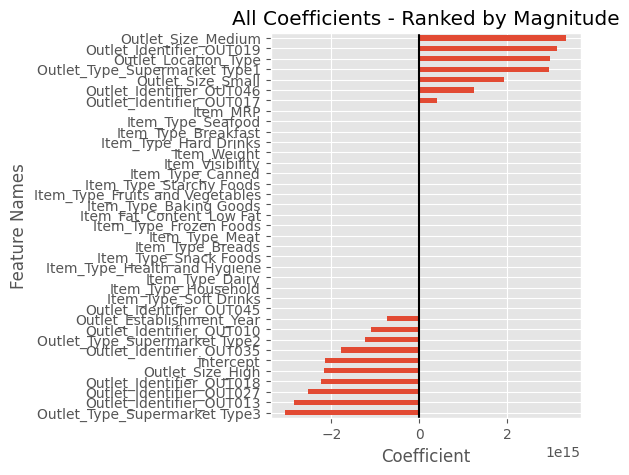

In [38]:
#extracting coefficients using function
coeffs = get_coeffs_linreg(lin_reg)
## plotting all coefficients and intercept
plot_coeffs(coeffs, intercept=True);

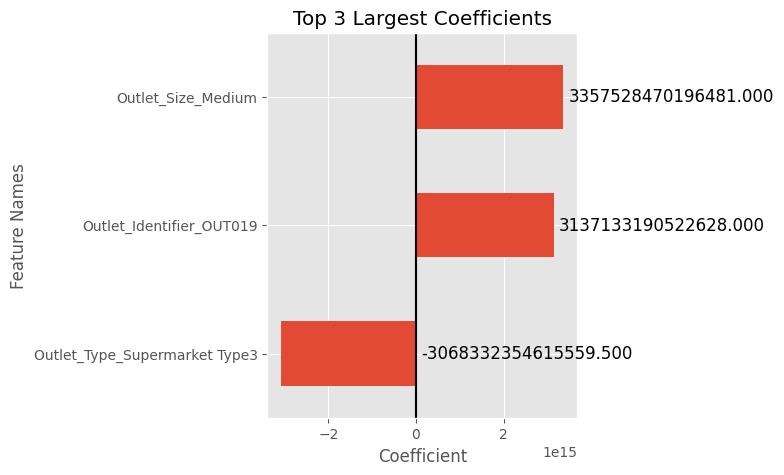

In [39]:
#plotting top 3 coefficients excluding intercept
plot_coeffs(coeffs, top_n=3, annotate=True);

###Evaluating Coefficients

All of my coefficients were categorical items. The 3 largest coefficients I have are: OUtlet_Size_Medium, Outlet_Identifier_OUT019 and Outlet_Type_Supermarket Type3. Belonging to these categories will have the following changes to the target:
- Outlet_Size_Medium : 33577528470196481 
- Outlet_Identifier_OUT019 : 3137133190522628
- Outlet_Type_Supermarket Type3 : (-3068332354615559.5)

### Serializing and Saving Model

In [40]:
## creating a dictionary of all of the variables to save for later
export_linreg = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'LinearRegressor':lin_reg}
joblib.dump(export_linreg, 'linear_regressor.joblib')

['linear_regressor.joblib']

### Model 2 - DecisionTree

In [41]:
#instantiating model
dec = DecisionTreeRegressor(random_state=SEED)
#fitting data on processed training dataframe
dec.fit(X_train_df,y_train)
#evaluating model using function
evaluate_regression(dec, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.21	RMSE= 1558.44


### Tuning Model Using GridSearchCV

In [42]:
#viewing available parametors for this model
dec.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 321,
 'splitter': 'best'}

In [43]:
#verify the decision tree depth
dec.get_depth()

36

In [44]:
#creating parameter grid to test
dec_param_grid = {'max_depth': list(range(0, 44)),
              'max_features': list(range(0, 13))}

In [45]:
#creating grid search
dec_gs = GridSearchCV(dec, dec_param_grid)

In [46]:
#fitting grid search
dec_gs.fit(X_train_df, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
280 fits failed out of a total of 2860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _val

GridSearchCV(estimator=DecisionTreeRegressor(random_state=321),
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...],
                         'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12]})

In [47]:
#displaying best parameters
dec_gs.best_params_

{'max_depth': 7, 'max_features': 12}

### Optimized DecisionTree Model

In [48]:
#instantiating model
dec = DecisionTreeRegressor(max_depth=7, max_features=12, random_state=SEED)
#fitting data on processed training dataframe
dec.fit(X_train_df,y_train)
#evaluating model using function
evaluate_regression(dec, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.61	RMSE= 1054.65
Test Data:	R^2= 0.59	RMSE= 1131.28


### Feature Importances

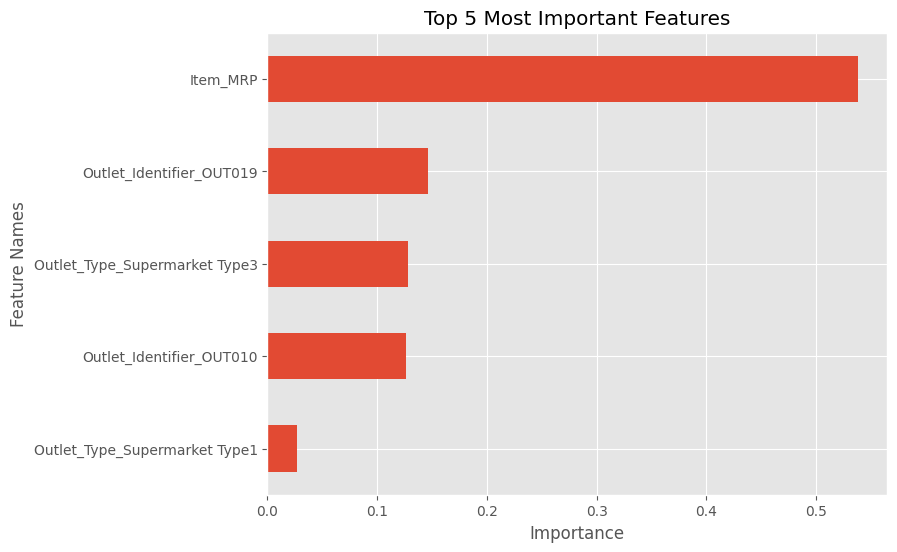

In [49]:
## Saving the feature importances using function
importances = get_importances(dec)
#plotting the top 5 important features using function
plot_importance(importances, top_n=5);

### Permutation Importances

In [50]:
## Permutation importance takes a fit model and the test data.
r = permutation_importance(dec, X_test_df, y_test,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [51]:
## pull out mean importances from above dictionary and convert into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

Item_MRP                           0.70
Outlet_Type_Supermarket Type3      0.21
Outlet_Identifier_OUT010           0.17
Outlet_Identifier_OUT019           0.14
Outlet_Type_Supermarket Type1      0.08
Outlet_Identifier_OUT018           0.02
Outlet_Size_Medium                 0.00
Outlet_Establishment_Year          0.00
Item_Fat_Content_Low Fat           0.00
Item_Type_Breakfast                0.00
Item_Weight                        0.00
Outlet_Identifier_OUT045           0.00
Outlet_Identifier_OUT017           0.00
Item_Type_Hard Drinks              0.00
Item_Type_Household                0.00
Item_Type_Soft Drinks              0.00
Outlet_Identifier_OUT027           0.00
Outlet_Type_Supermarket Type2      0.00
Outlet_Location_Type               0.00
Outlet_Size_Small                  0.00
Outlet_Size_High                   0.00
Item_Type_Starchy Foods            0.00
Outlet_Identifier_OUT046           0.00
Outlet_Identifier_OUT013           0.00
Outlet_Identifier_OUT035           0.00


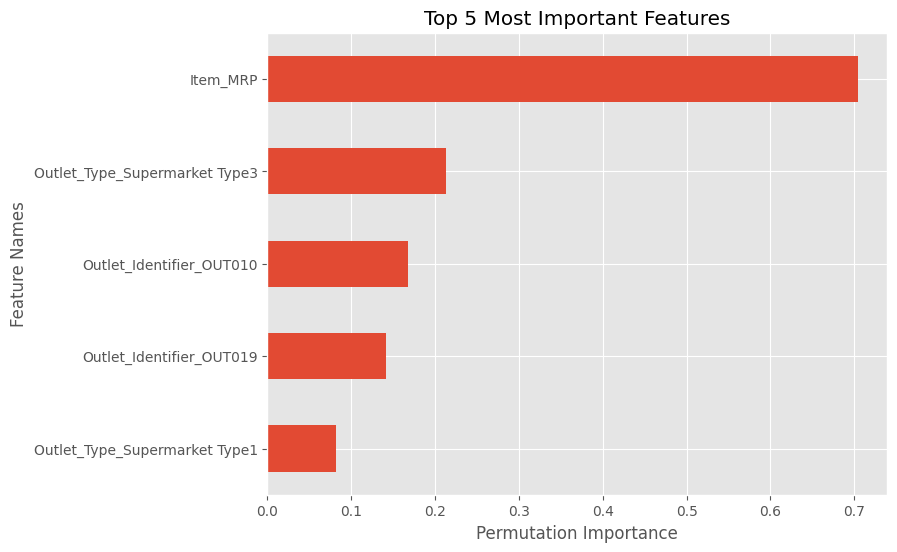

In [52]:
#use function to plot top 5 permutation importance
ax = plot_importance(permutation_importances,top_n=5)
ax.set(xlabel='Permutation Importance');

### Serializing and Saving Model

In [53]:
## creating a dictionary of all of the variables to save for later
export_dec = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'DecisionTree':dec}
joblib.dump(export_dec, 'decision_tree.joblib')

['decision_tree.joblib']

Comparing both the Decision Tree and Linear Regression models, the Decision Tree Model performed better overall. I utilized various regression metrics to evaluate and compare both models and the Decision Tree model had better results.

Although I was able to improve the Decision tree model in its prediction perfomance, I would hightly recommned gathering other relevant features that would help with Item Sales predictions. It can be concluded that this model has a high bias which would not be super reliable when making predictions.